# Preliminary EDA + Dimensionality Reduction
Not much to show in this notebook. Just preliminary analysis, basic dimensionality reduction using Chi-Squared Feature Selection, LSA, NMF, and LDA and some basic classification attempts.

In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import string
import seaborn as sns

from scipy import stats
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import text

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, SGDClassifier
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import nltk

import pyLDAvis.gensim
import json

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

In [99]:
pickle_in = open("character_scripts","rb")
character_scripts = pickle.load(pickle_in)
pickle_in = open("merged","rb")
merged = pickle.load(pickle_in)

In [100]:
#Script Line Counts
counts = [[key,len(merged[key])] for key in merged]
countspd = pd.DataFrame(counts, columns=["Name","Counts"])
countspd.sort_values(by='Counts', ascending=False).head(15)

,Name,Counts
0,Fry,3926
11,Bender,3670
8,Leela,3116
20,Farnsworth,1519
27,Zoidberg,975
28,Amy,910
26,Hermes,843
63,Zapp,500
887,Professor Farnsworth,284
64,Kif,253


In [4]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser','ner'])

/Users/isaackim/anaconda3/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
/Users/isaackim/anaconda3/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable


In [5]:
#My personal preprocessing: eliminate punctuation, remove lines under 3 words long, spacy lemmatization
def remove_punctuation(text):
    return "".join([ch.lower() for ch in text if ch not in string.punctuation])

def spacy_lines(lines):
    docs = [nlp(sentence) for sentence in lines]
    cleaned = [" ".join([token.lemma_ for token in sentence]) for sentence in docs]
    preprocess = [remove_punctuation(content.strip('\n')).strip() for content in cleaned]
    preprocess_words = [line.split() for line in preprocess]
#     sentences = [line for line in preprocess_words if len(line) > 4]
    str_sentences = [" ".join([token for token in sentence]) for sentence in preprocess_words]
    return str_sentences

def spacy_preprocess(dictionary):
    return {key:spacy_lines(value) for (key,value) in dictionary.items()}

In [6]:
spacy_dict = spacy_preprocess(character_scripts)

In [7]:
# Creating output column for my classification
Characters = ['Fry','Bender','Leela','Farnsworth','Zoidberg','Amy','Hermes','Zapp','Kif']
lengths = [len(spacy_dict[char]) for char in Characters]
positions = list(np.cumsum(lengths))
identifiers = [y for x in [[i]*lengths[i] for i in range(len(Characters))] for y in x]
names = [y for x in [[Characters[i]]*lengths[i] for i in range(len(Characters))] for y in x]
char_dict = dict(zip(Characters,range(10)))
spacy_lines = spacy_dict['Fry'] + spacy_dict['Bender'] + spacy_dict['Leela'] + spacy_dict['Farnsworth'] + spacy_dict['Zoidberg'] + spacy_dict['Amy'] + spacy_dict['Hermes'] + spacy_dict['Zapp'] + spacy_dict['Kif']  

In [8]:
with open("spacy_lines","wb") as pickle_out:
    pickle.dump(spacy_lines, pickle_out)

In [9]:
df = pd.DataFrame([spacy_lines, names, identifiers]).transpose()
df = df.rename(columns = {0:'line',1:'name',2:'char_id'})
name_to_id = dict(df[['name','char_id']].drop_duplicates().sort_values('char_id').values)

In [10]:
with open("df","wb") as pickle_out:
    pickle.dump(df, pickle_out)

In [11]:
pickle_in = open("df","rb")
df = pickle.load(pickle_in)
pickle_in = open("spacy_lines","rb")
spacy_lines = pickle.load(pickle_in)

## Analysis + Classification with TfidfVectorizer

In [12]:
#Creating custom stop word lists to try
with open('stoplist.txt','r') as f:
    contents = f.readlines()
stop = [remove_punctuation(content.strip('\n')) for content in contents]
my_stop_words = text.ENGLISH_STOP_WORDS.union(['fry','leela','bender','zoidberg','professor','amy','pron','s','oh'])
my_stop_words2 = text.ENGLISH_STOP_WORDS.union(['pron','s','oh'])

In [13]:
# Add additional stop words that commonly occur but don't add much value
stop_list = stop + ['fry','leela','bender','zoidberg','professor','amy','whoa','yeah','ha','ho','sit','oh','s',
                    'love','great','pron','will','hey']

### Using chi2 feature selection

In [15]:
#sklearn chi2 feature selection
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for name, char_id in sorted(name_to_id.items()):
  features_chi2 = chi2(features, labels == char_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(name))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Amy':
  . Most correlated unigrams:
. buh
. kif
  . Most correlated bigrams:
. fun feel
. uh mom
# 'Bender':
  . Most correlated unigrams:
. elzar
. ass
  . Most correlated bigrams:
. shiny metal
. metal ass
# 'Farnsworth':
  . Most correlated unigrams:
. news
. wha
  . Most correlated bigrams:
. eh wha
. good news
# 'Fry':
  . Most correlated unigrams:
. seymour
. future
  . Most correlated bigrams:
. wanna hear
. wait minute
# 'Hermes':
  . Most correlated unigrams:
. labarbara
. mon
  . Most correlated bigrams:
. bird dog
. mon hell
# 'Kif':
  . Most correlated unigrams:
. rustler
. sir
  . Most correlated bigrams:
. um sir
. um um
# 'Leela':
  . Most correlated unigrams:
. surface
. yah
  . Most correlated bigrams:
. save animal
. dark matter
# 'Zapp':
  . Most correlated unigrams:
. neutral
. kif
  . Most correlated bigrams:
. kif woman
. sham pag
# 'Zoidberg':
  . Most correlated unigrams:
. hooray
. claw
  . Most correlated bigrams:
. hermes friend
. woop woop


In [103]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['line'], df['name'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [104]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [49]:
clf.score(X_train_tfidf, y_train)

0.5234338747099768

In [50]:
clf.score(X_test_tfidf, y_test)

0.3101529902642559

In [40]:
print(clf.predict(count_vect.transform([X_test.iloc[423]])))

['Fry']


In [47]:
lr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='auto',max_iter=1000)
lr.fit(X_train_tfidf,y_train);

In [42]:
lr.score(X_train_tfidf,y_train)

0.7883990719257541

In [43]:
lr.score(X_test_tfidf,y_test)

0.4659248956884562

In [44]:
y_test.iloc[100]

'Leela'

In [45]:
print(lr.predict(count_vect.transform([X_test.iloc[423]])))

['Leela']


In [33]:
MNB = MultinomialNB()

In [108]:
labels = labels.astype(int)

In [35]:
cross_val_score(MNB, features, labels, cv=5, scoring = 'accuracy')

array([0.34315425, 0.35590278, 0.32521739, 0.3641115 , 0.33391608])

In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(solver = 'lbfgs', multi_class = 'auto'),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

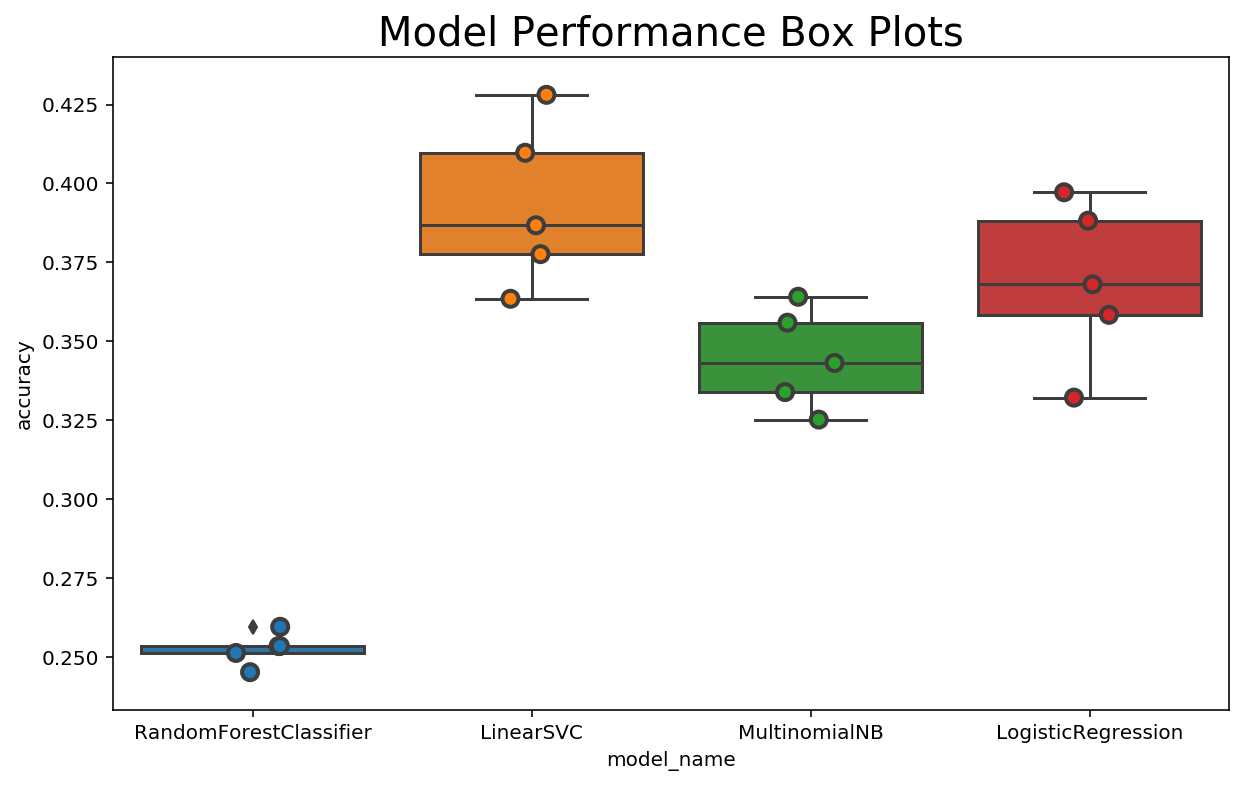

In [110]:
import seaborn as sns
plt.figure(figsize = (10,6))
plt.title("Model Performance Box Plots", fontsize = 20)
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, edgecolor="gray", linewidth=2);


In [38]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.393132
LogisticRegression        0.368810
MultinomialNB             0.344460
RandomForestClassifier    0.252614
Name: accuracy, dtype: float64

## LSA

In [39]:
vectorizer = CountVectorizer(stop_words=stop_list, preprocessor = remove_punctuation, 
                             max_df = .99, min_df=2, token_pattern=r'\b[a-zA-Z]+\b', ngram_range = (1,2))
doc_word = vectorizer.fit_transform(spacy_lines)
doc_word.shape

(2874, 6791)

In [40]:
data = pd.DataFrame(doc_word.toarray(), columns=vectorizer.get_feature_names())

In [41]:
lsa = TruncatedSVD(8)
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_

array([0.00687139, 0.00869479, 0.00840116, 0.0078311 , 0.00700559,
       0.0062116 , 0.00600497, 0.00579786])

In [42]:
Counter(np.argmax(doc_topic, axis=1))

Counter({0: 2141, 5: 88, 7: 110, 3: 159, 1: 137, 2: 157, 6: 73, 4: 9})

In [62]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [44]:
display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
good, time, uh, thing, robot, wait, man, life, friend, guy

Topic  1
uh, time, man, coffee, huh, uh huh, uh uh, kif, alright, guy

Topic  2
time, year, machine, feel, time machine, life, forward, thing, travel, skip

Topic  3
robot, human, body, guy, friend, life, kill, god, robot robot, die

Topic  4
uh, time, good, robot, coffee, news, good news, uh uh, machine, friend

Topic  5
ow, wait, ow ow, ooh, god, guy, bad, second, head, wait second

Topic  6
wait, man, god, kill, kif, alright, second, word, planet, captain

Topic  7
wait, life, coffee, second, find, thing, wait second, live, work, year


In [51]:
pickle_in = open("character_scripts","rb")
character_scripts = pickle.load(pickle_in)

In [52]:
def scale(X_train, X_test):
    std = StandardScaler()
    std.fit(X_train.values)
    X_tr = std.transform(X_train.values)
    X_te = std.transform(X_test.values)
    return X_tr, X_te

In [53]:
vectorizer2 = TfidfVectorizer(stop_words=my_stop_words2, preprocessor = remove_punctuation, 
                             max_df = 100, min_df=2, token_pattern=r'\b[a-zA-Z]+\b', ngram_range = (1,3))
doc_word2 = vectorizer2.fit_transform(spacy_lines)
doc_word2.shape

(2874, 9602)

## NMF

In [54]:
nmf_model = NMF(20)
doc_topic3 = nmf_model.fit_transform(doc_word2)

In [55]:
Counter(np.argmax(doc_topic3, axis=1))

Counter({14: 161,
         13: 132,
         0: 579,
         2: 68,
         19: 311,
         16: 116,
         10: 48,
         8: 104,
         6: 93,
         17: 269,
         1: 69,
         4: 81,
         12: 191,
         15: 138,
         18: 44,
         9: 60,
         11: 102,
         5: 108,
         7: 94,
         3: 106})

In [56]:
nmf_df = pd.DataFrame(doc_topic3)
id_df = pd.DataFrame(identifiers)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(nmf_df, id_df[0], test_size=0.3, random_state=41)
X_tr, X_te = scale(X_train, X_test)

In [58]:
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
print("The score for MNB is")
print("Training: {:6.2f}%".format(100*mnb.score(X_tr, y_train)))
print("Test set: {:6.2f}%".format(100*mnb.score(X_te, y_test)))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_tr, y_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_tr, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_te, y_test)))

dtc = DecisionTreeClassifier(max_depth=3)
dtc.fit(X_train, y_train)
print("The score for Decision Tree is")
print("Training: {:6.2f}%".format(100*dtc.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*dtc.score(X_test, y_test)))

svc = LinearSVC(max_iter = 10000)
svc.fit(X_tr,y_train)
print("The score for LinearSVC is")
print("Training: {:6.2f}%".format(100*svc.score(X_tr, y_train)))
print("Test set: {:6.2f}%".format(100*svc.score(X_te, y_test)))

The score for MNB is
Training:  33.17%
Test set:  31.98%
The score for kNN is
Training:  49.93%
Test set:  30.24%
The score for Decision Tree is
Training:  31.48%
Test set:  27.93%
The score for LinearSVC is
Training:  34.61%
Test set:  31.98%


/Users/isaackim/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [80]:
rfc = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
rfc.fit(X_tr,y_train)
print("The score for Random Forest Classifier is")
print("Training: {:6.2f}%".format(100*rfc.score(X_tr, y_train)))
print("Test set: {:6.2f}%".format(100*rfc.score(X_te, y_test)))

The score for Random Forest Classifier is
Training:  34.96%
Test set:  30.36%


In [81]:
xgb = XGBClassifier()
xgb.fit(X_tr, y_train)
print("The score for XGBoost is")
print("Training: {:6.2f}%".format(100*xgb.score(X_tr, y_train)))
print("Test set: {:6.2f}%".format(100*xgb.score(X_te, y_test)))

The score for XGBoost is
Training:  59.47%
Test set:  35.23%


In [60]:
sgd = SGDClassifier()
sgd.fit(X_tr, y_train)
print("The score for Stochastic Gradient Descent with Support Vector Machines is")
print("Training: {:6.2f}%".format(100*sgd.score(X_tr, y_train)))
print("Test set: {:6.2f}%".format(100*sgd.score(X_te, y_test)))

The score for Stochastic Gradient Descent with Support Vector Machines is
Training:  28.44%
Test set:  27.58%


In [63]:
display_topics(nmf_model, vectorizer2.get_feature_names(), 10)


Topic  0
earth, wow, world, tv, okay, minute, kid, cool, lot, miss

Topic  1
sir, sir sir, um, earth, yes sir, actually, aye, um sir, actually sir, sir shall

Topic  2
whoa, whoa whoa, whoa whoa whoa, look like, wash, whoa slow, offensive, whoa whoa slow, slow, object

Topic  3
kif, woman, snu, betsy, ready, party, kroker, poor, forever, wave

Topic  4
huh, uh huh, slurm, huh hey, blah, huh uh, uh huh uh, calculon, blah blah, huh uh huh

Topic  5
body, switch, switch body, mind, bender body, use body, robot body, nixon, fabulous, original

Topic  6
human, kill human, point, light, know human, calculon, eye, beep, blood, race

Topic  7
ass, metal, shiny, shiny metal, bite, metal ass, shiny metal ass, bite shiny metal, bite shiny, cmon

Topic  8
captain, zapp, brannigan, zapp brannigan, animal, new captain, mutiny, space, leela captain, know zapp

Topic  9
shut, gill, slurm, shut shut, yeah shut, bunk, love shut, fry shut, want leela, english

Topic  10
bend, bend bend, angle, bender be

### LDA Attempt #1
The much more rigorous attempt at LDA is on the other notebook

In [64]:
pickle_in = open("all_lines","rb")
all_lines = pickle.load(pickle_in)

In [65]:
STOPWORDS2 = list(STOPWORDS) + ['bender','fry','leela','farnsworth','zoidberg','amy']
STOPWORDS3 = frozenset(STOPWORDS2)

In [66]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/isaackim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [67]:
def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [68]:
doc_sample = all_lines[0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['', '', 'Space.', 'It', 'seems', 'to', 'go', 'on', 'and', 'on', 'forever.', 'But', 'then', 'you', 'get', 'to', 'the', 'end', 'and', 'the', 'gorilla', 'starts', 'throwing', 'barrels', 'at', 'you.', 'And', "that's", 'how', 'you', 'play', 'the', 'game!', 'Michelle,', 'baby!', 'Where', 'you', 'going?', 'I', 'hate', 'my', 'life,', 'I', 'hate', 'my', 'life,', 'I', 'hate', 'my', 'life.', 'Hello?', 'Pizza', 'delivery', 'for,', 'uh', '...', '', "Here's", 'to', 'another', 'lousy', 'millennium.']


 tokenized and lemmatized document: 
['space', 'forev', 'gorilla', 'start', 'throw', 'barrel', 'play', 'game', 'michell', 'babi', 'go', 'hate', 'life', 'hate', 'life', 'hate', 'life', 'hello', 'pizza', 'deliveri', 'lousi', 'millennium']


In [69]:
lines = pd.DataFrame(all_lines)

In [70]:
processed_docs = lines[0].map(preprocess)

In [72]:
#Bag of Words
dictionary = gensim.corpora.Dictionary(processed_docs)

In [73]:
dictionary.filter_extremes(no_below=2, no_above=0.5)

In [74]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [75]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=8, id2word=dictionary, passes=50, workers=3, chunksize=50)

In [76]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.333713382731334


In [77]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [78]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=bow_corpus, texts=processed_docs, start=2, limit=40, step=6)

The best coherence value occurs at 26 topics or so.

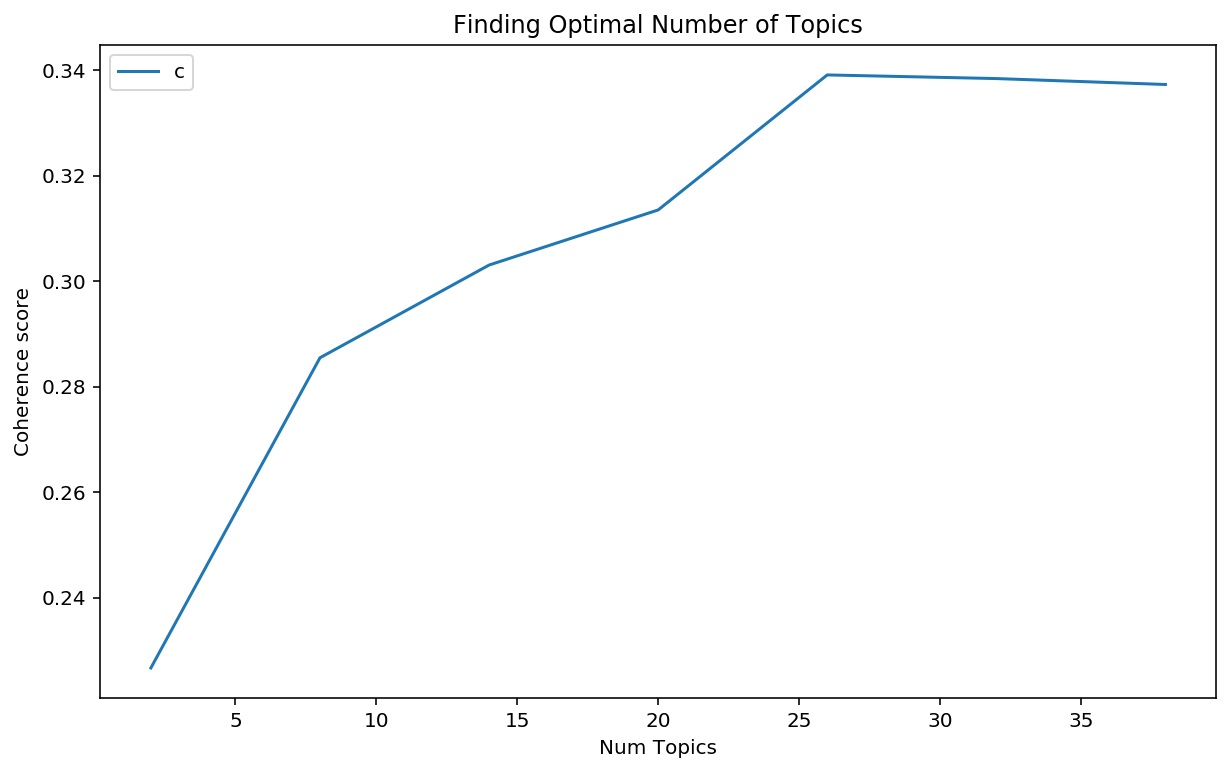

In [79]:
# Show graph
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 6)
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.title("Finding Optimal Number of Topics")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [80]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=26, id2word=dictionary, passes=100, workers=4, chunksize=100)

In [81]:
lda_corpus = [lda_model[line] for line in bow_corpus]

In [86]:
train_vecs = []
for i in range(len(lda_corpus)):
    top_topics = lda_model.get_document_topics(lda_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[k][1] for k in range(len(top_topics))]
    train_vecs.append(topic_vec)

lda_df = pd.DataFrame(train_vecs)
id_df = pd.DataFrame(identifiers)

In [87]:
X = np.array(train_vecs)
y = np.array(identifiers)

In [88]:
y = id_df[0]
X = lda_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)
X_tr, X_te = scale(X_train, X_test)

In [89]:
clf = MultinomialNB()
clf.fit(X_train,y_train)
print("The score for MNB is")
print("Training: {:6.2f}%".format(100*clf.score(X_tr, y_train)))
print("Test set: {:6.2f}%".format(100*clf.score(X_te, y_test)))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_tr, y_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_tr, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_te, y_test)))

The score for MNB is
Training:  28.15%
Test set:  24.80%
The score for kNN is
Training:  46.89%
Test set:  26.77%


In [90]:
xgb = XGBClassifier()
xgb.fit(X_tr, y_train)
print("The score for XGBoost is")
print("Training: {:6.2f}%".format(100*xgb.score(X_tr, y_train)))
print("Test set: {:6.2f}%".format(100*xgb.score(X_te, y_test)))

The score for kNN is
Training:  49.93%
Test set:  29.08%


In [93]:
sgd = SGDClassifier()
sgd.fit(X_tr, y_train)
print("The score for SGD is")
print("Training: {:6.2f}%".format(100*sgd.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*sgd.score(X_test, y_test)))

The score for SGD is
Training:  24.47%
Test set:  24.80%
